In [30]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import celltypist
from celltypist import models

# 设置默认保存路径
sc.settings.figdir = "pbmc_figures"

In [31]:
adata = sc.read_h5ad('pbmc_harmony.h5ad')

In [32]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30, use_rep='X_pca_harmony')
sc.tl.umap(adata)

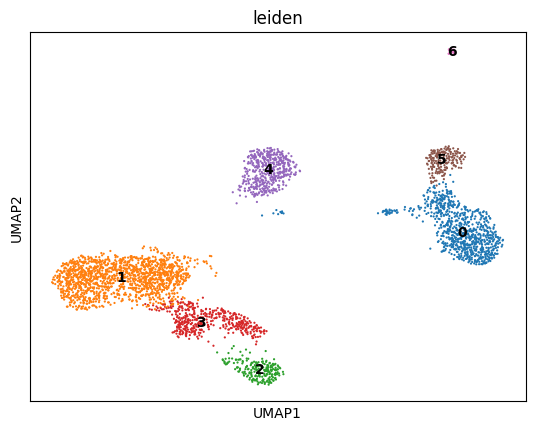

In [33]:
sc.tl.leiden(
    adata,
    resolution=0.3,
    random_state=0,
    key_added='leiden',
    flavor="igraph" # leidenalg或igraph；leidenalg依赖于igraph
)
sc.pl.umap(adata, color=['leiden'], use_raw=False, vmax = 4, 
           add_outline =False, size = 10, sort_order=True,legend_loc='on data',
           ncols=5)#, save='.PBMC.png')

### Known Markers

In [34]:
markers = ["CD3D","CD4", # CD4T
    "CD3D","CD8A","CD8B","NCAM1","NCR1", # CD8T
    "CD79A", # B
    "CD34", # HSPC
    "CD68","AIF1", # myeloid
    "IL7R","NCR1","KLRC1","KLRD1"] # ILC NK

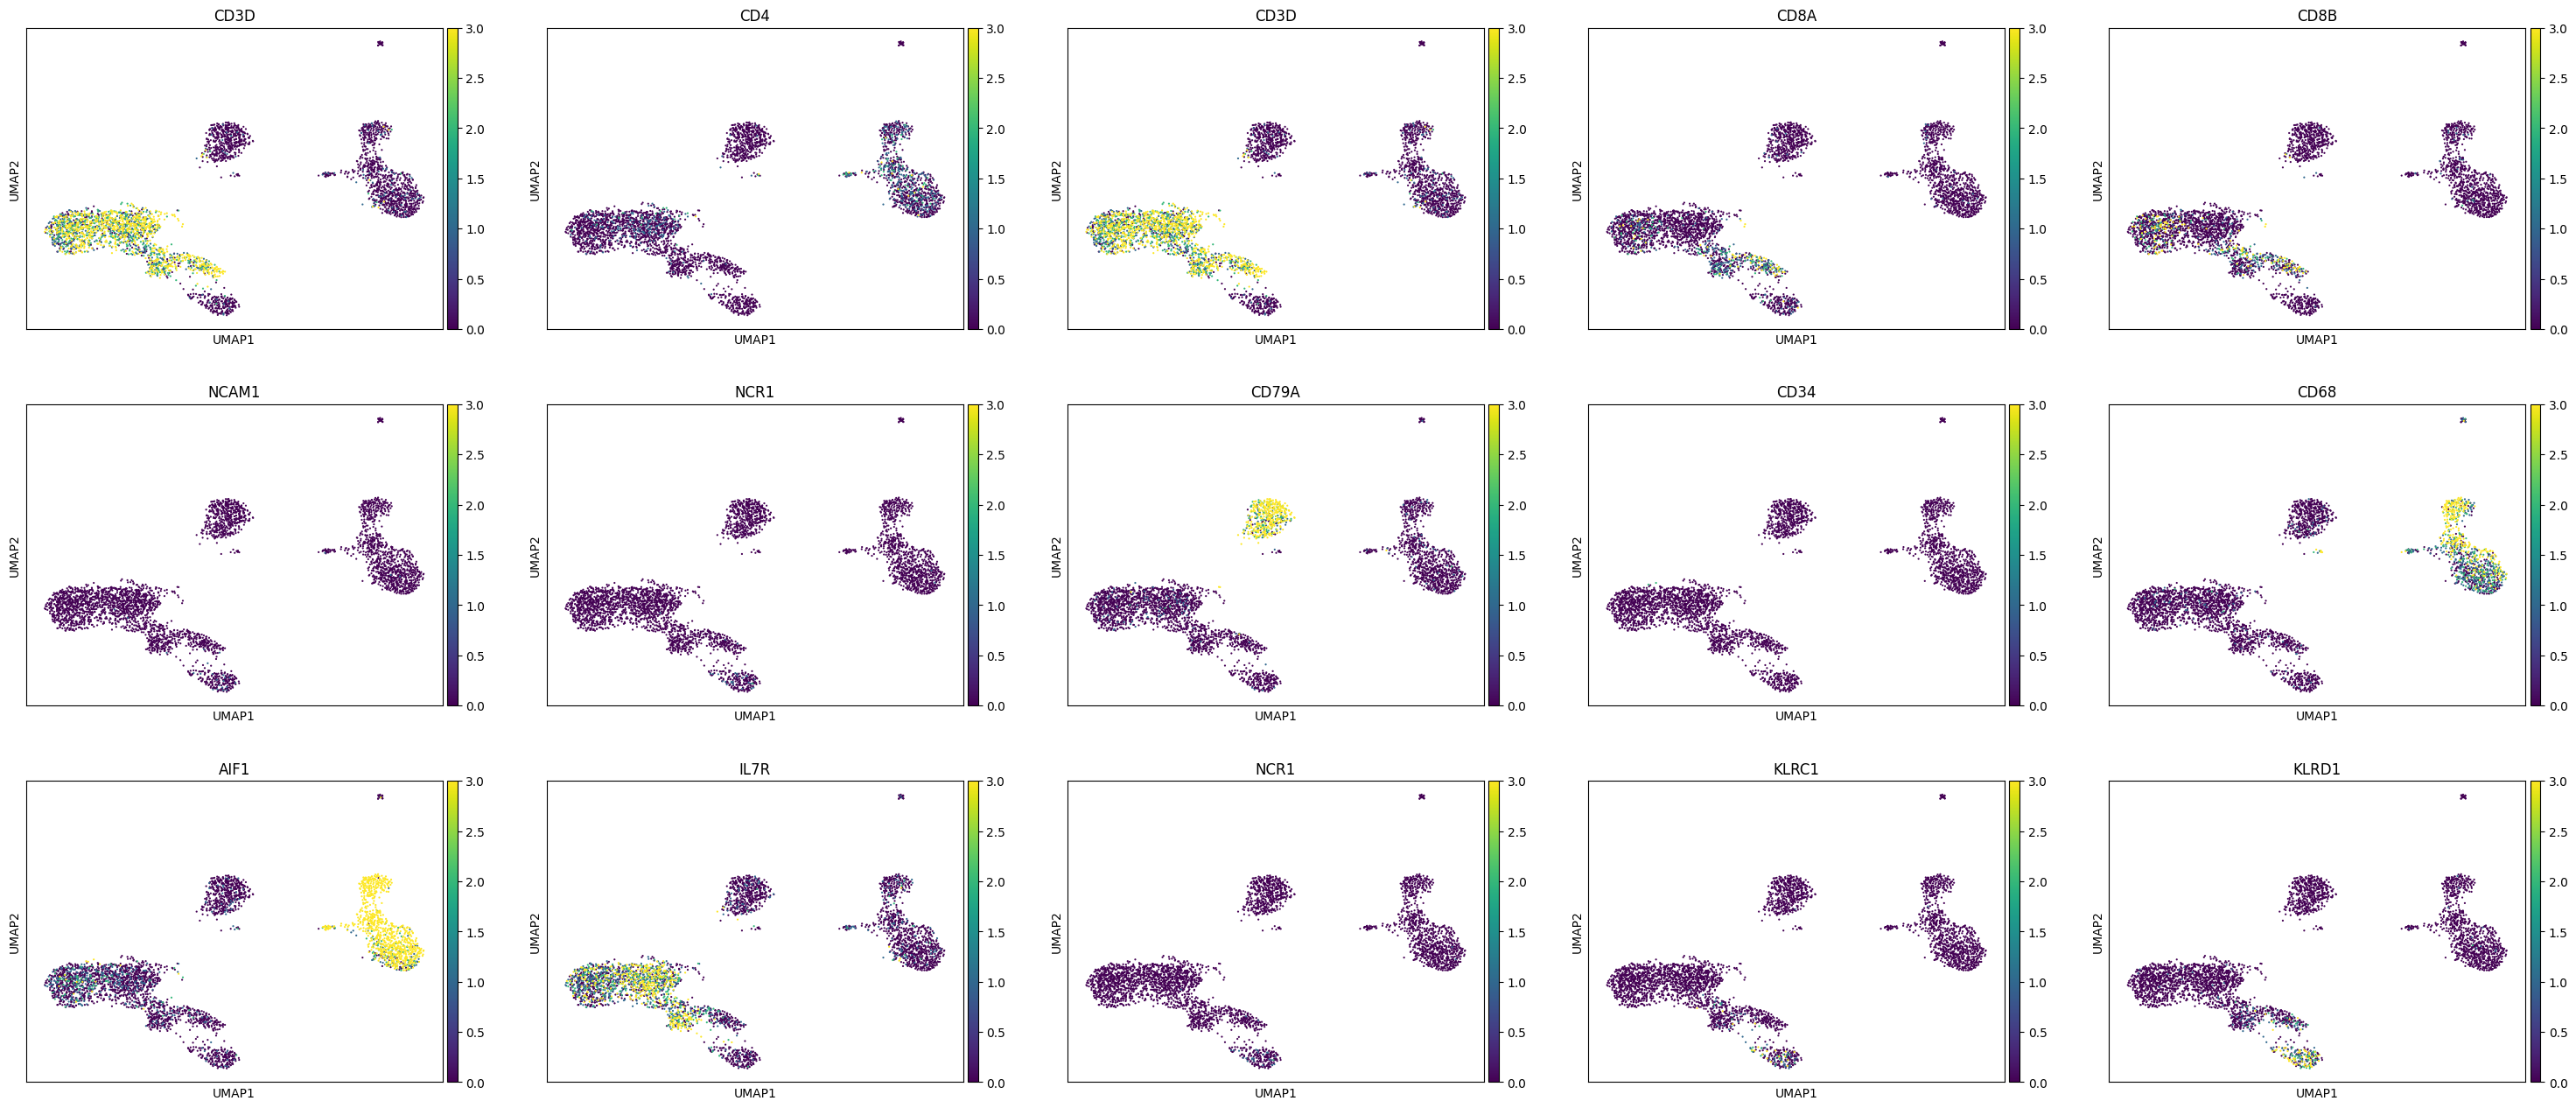

In [35]:
sc.pl.umap(adata, color = markers, use_raw=False, layer='counts',vmax = 3, 
           add_outline =False, size = 10, sort_order=True,
           ncols=5)#, save='.PBMC.leiden05.png')

categories: 0, 1, 2, etc.
var_group_labels: Myeloid, monocytes, DC, etc.


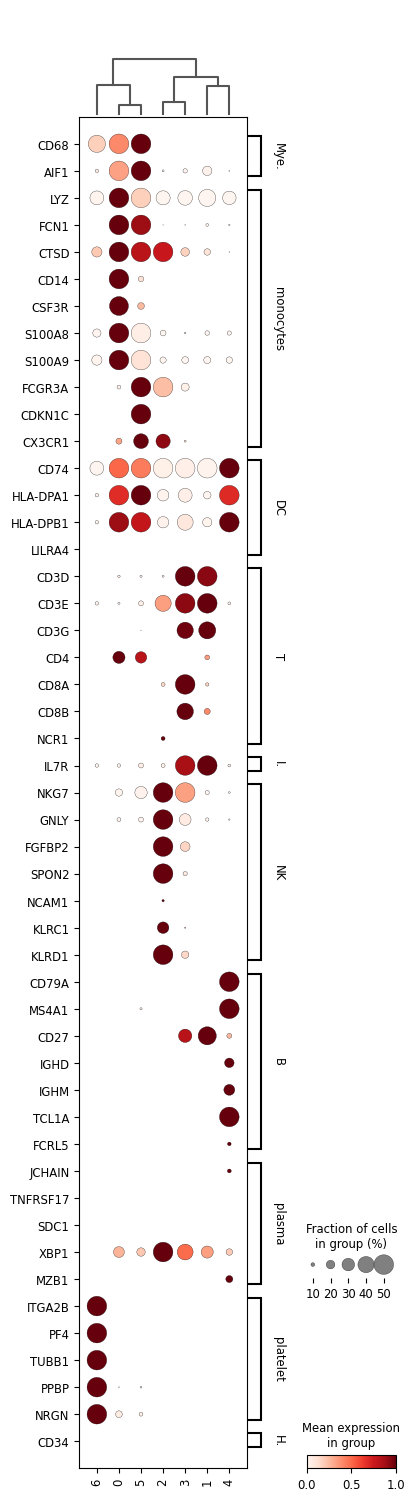

In [36]:
marker_genes = {
    'Myeloid': ["CD68","AIF1"],
    'monocytes': ["LYZ","FCN1","CTSD", "CD14", "CSF3R", "S100A8", "S100A9", "FCGR3A", "CDKN1C", "CX3CR1"],
    'DC': ["CD74", "HLA-DPA1", "HLA-DPB1", "LILRA4"],
    'T': ["CD3D", "CD3E", "CD3G", "CD4", "CD8A", "CD8B", "NCR1"],
    'ILC': ["IL7R"], 
    'NK': ["NKG7", "GNLY", "FGFBP2", "SPON2", "NCAM1", "KLRC1", "KLRD1"],
    'B': ["CD79A", "MS4A1", "CD27", "IGHD", "IGHM", "TCL1A", "FCRL5"],
    'plasma': ["JCHAIN", "TNFRSF17", "SDC1","XBP1","MZB1"],
    'platelet':  ["ITGA2B", "PF4", "TUBB1", "PPBP", "NRGN"],
    'HSPC': ["CD34"],
}

# standard_scale Optional[Literal['var', 'group']] (default: None)
# meaning for each variable or group, subtract the minimum and divide each by its maximum.
sc.pl.dotplot(adata, var_names=marker_genes, groupby='leiden', dendrogram=True, layer='counts',
              colorbar_title='Mean expression\nin group', size_title='Fraction of cells\nin group (%)',
              cmap='Reds', dot_max=0.5, dot_min=0.05, swap_axes=True, standard_scale='var',)


categories: 0, 1, 2, etc.
var_group_labels: Myeloid, monocytes, DC, etc.


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

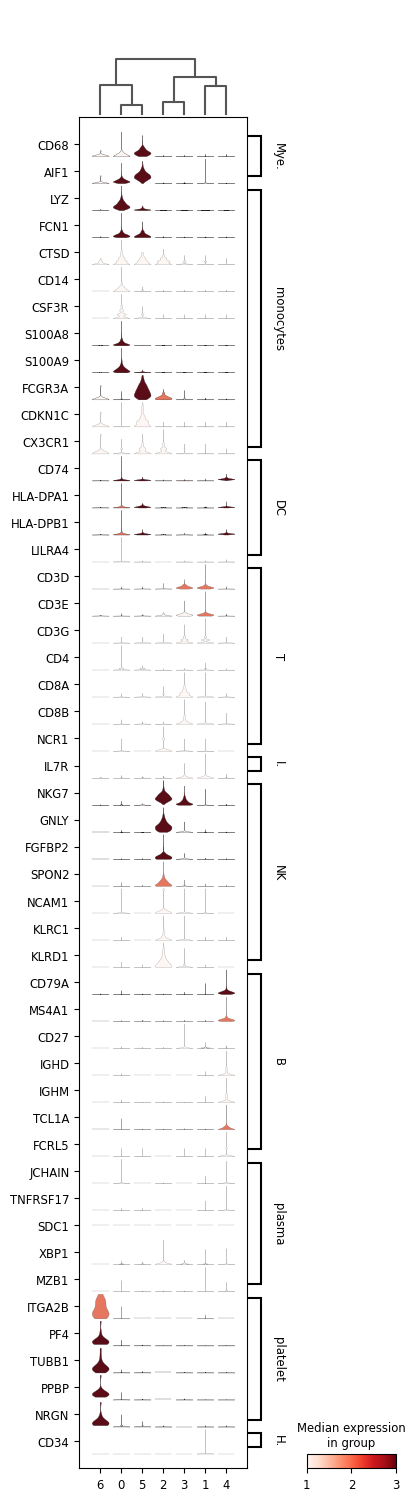

In [37]:
sc.pl.stacked_violin(adata, var_names=marker_genes, groupby='leiden', layer='counts',
                     dendrogram=True, colorbar_title='Median expression\nin group', 
                     cmap='Reds', vmin=1, vmax=3, swap_axes=True)#, save='stacked_violin_plot.png')


In [38]:
cl_annotation = {
    "0": "Myeloid",
    "6": "Platelet",
    "2": "NK",
    "5": "Myeloid",  
    "1": "CD4 T",
    "3": "CD8 T",
    "4": "B",
}

... storing 'manual_celltype_annotation' as categorical


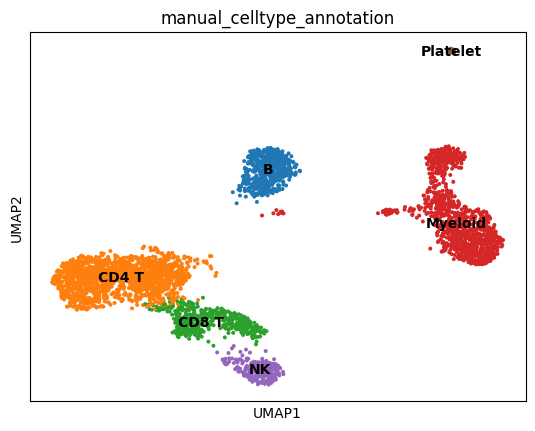

In [39]:
adata.obs["manual_celltype_annotation"] = adata.obs.leiden.map(cl_annotation)
sc.pl.umap(adata, color=["manual_celltype_annotation"],legend_loc='on data')

### DEG

In [59]:
sc.tl.rank_genes_groups(
    adata, groupby="leiden", method="wilcoxon", key_added="wilc_leiden"
)

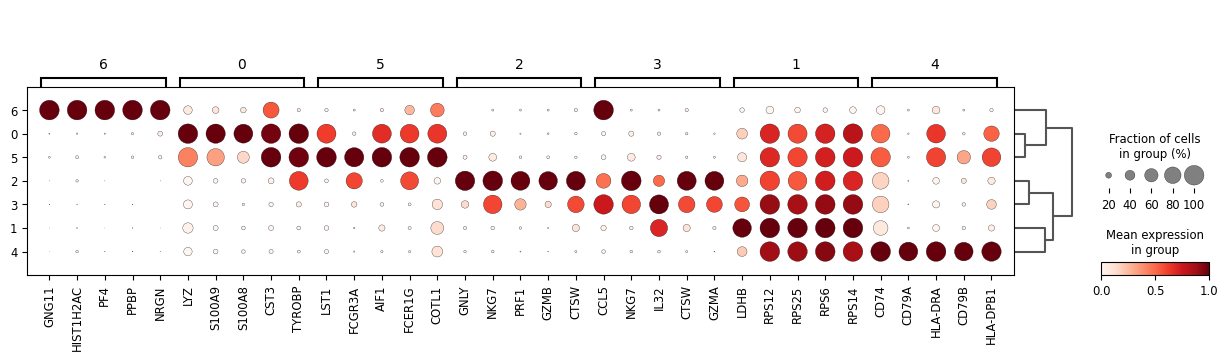

In [60]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5, key="wilc_leiden"
)

In [61]:
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="wilc_leiden",
    key_added="wilc_leiden_filtered",
)

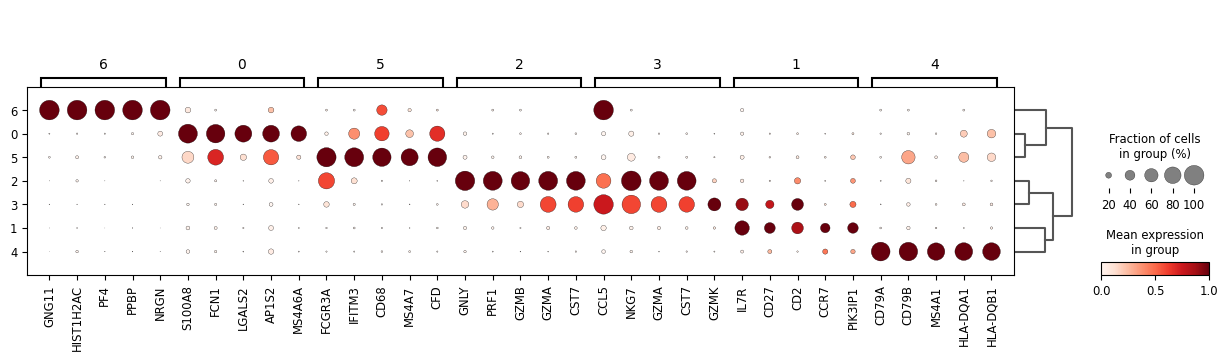

In [62]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden",
    standard_scale="var",
    n_genes=5,
    key="wilc_leiden_filtered",
)

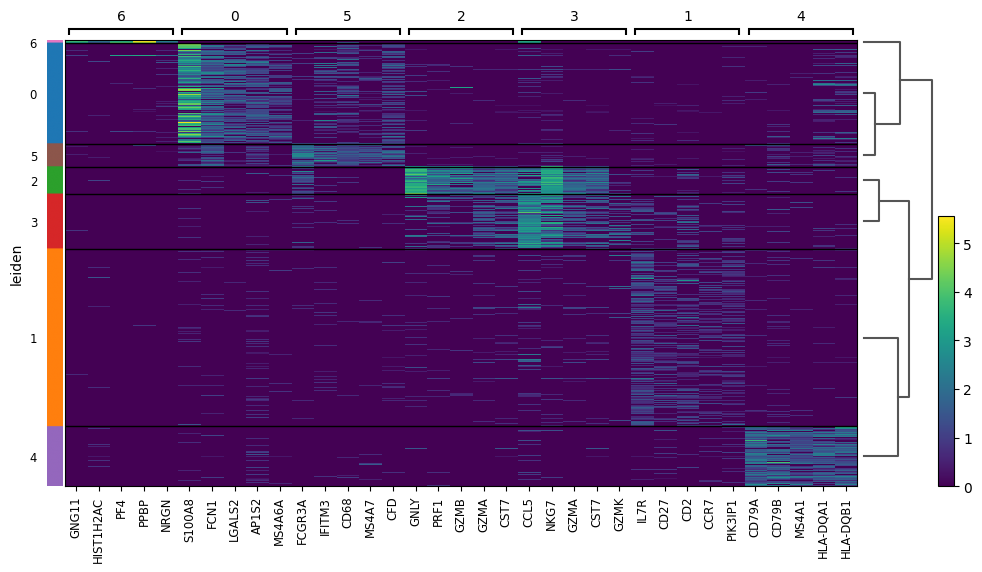

In [63]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, 
                                key="wilc_leiden_filtered", groupby="leiden", 
                                show_gene_labels=True)

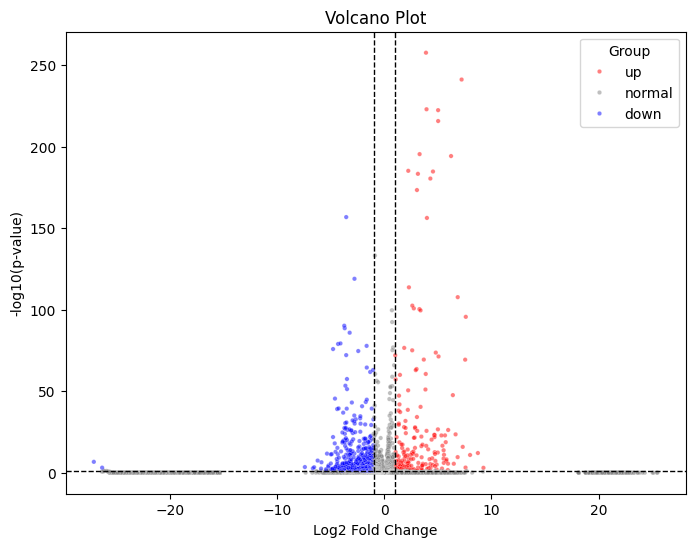

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置阈值
logfc_cutoff = 1
pval_cutoff = 0.05

# 提取差异表达结果
de_results = sc.get.rank_genes_groups_df(adata, group=['3','4'], key='wilc_leiden_filtered')

# 提取 log2 fold change 和 p-value
logfc = de_results['logfoldchanges']
pvals = de_results['pvals_adj']

# 转换为 DataFrame
df = pd.DataFrame({
    'log2fc': logfc.tolist(),
    'pval': pvals.tolist()
})

# 计算 -log10(p-value)
df['-log10(pval)'] = -np.log10(df['pval'])

# 分组
df['group'] = 'normal'
df.loc[(df['log2fc'] > logfc_cutoff) & (df['pval'] < pval_cutoff), 'group'] = 'up'
df.loc[(df['log2fc'] < -logfc_cutoff) & (df['pval'] < pval_cutoff), 'group'] = 'down'

# 绘制火山图
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='log2fc', y='-log10(pval)', hue='group', data=df,
    palette={'up': 'red', 'down': 'blue', 'normal': 'gray'},
    alpha=0.5, s=10
)

# 添加参考线
plt.axvline(x=logfc_cutoff, color='black', linestyle='--', linewidth=1)
plt.axvline(x=-logfc_cutoff, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-np.log10(pval_cutoff), color='black', linestyle='--', linewidth=1)

# 设置标签和标题
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot')

# 显示图例
plt.legend(title='Group', loc='upper right')

# 显示图形
plt.show()


### Automated Annotation

In [45]:
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata.layers["counts"].copy()  # set adata.X to raw counts
sc.pp.normalize_total(
    adata_celltypist, target_sum=10**4
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X.toarray()
models.download_models(
    force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"]
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /Users/secretloong/.celltypist/data/models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


In [46]:
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")

In [47]:
model_high.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

In [48]:
predictions_high = celltypist.annotate(
    adata_celltypist, model=model_high, majority_voting=True
)

🔬 Input data has 3666 cells and 48678 genes
🔗 Matching reference genes in the model
🧬 6067 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [49]:
predictions_high_adata = predictions_high.to_adata()

In [50]:
adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "conf_score"
]

In [51]:
predictions_low = celltypist.annotate(
    adata_celltypist, model=model_low, majority_voting=True
)

🔬 Input data has 3666 cells and 48678 genes
🔗 Matching reference genes in the model
🧬 6067 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [52]:
predictions_low_adata = predictions_low.to_adata()

In [53]:
adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "conf_score"
]

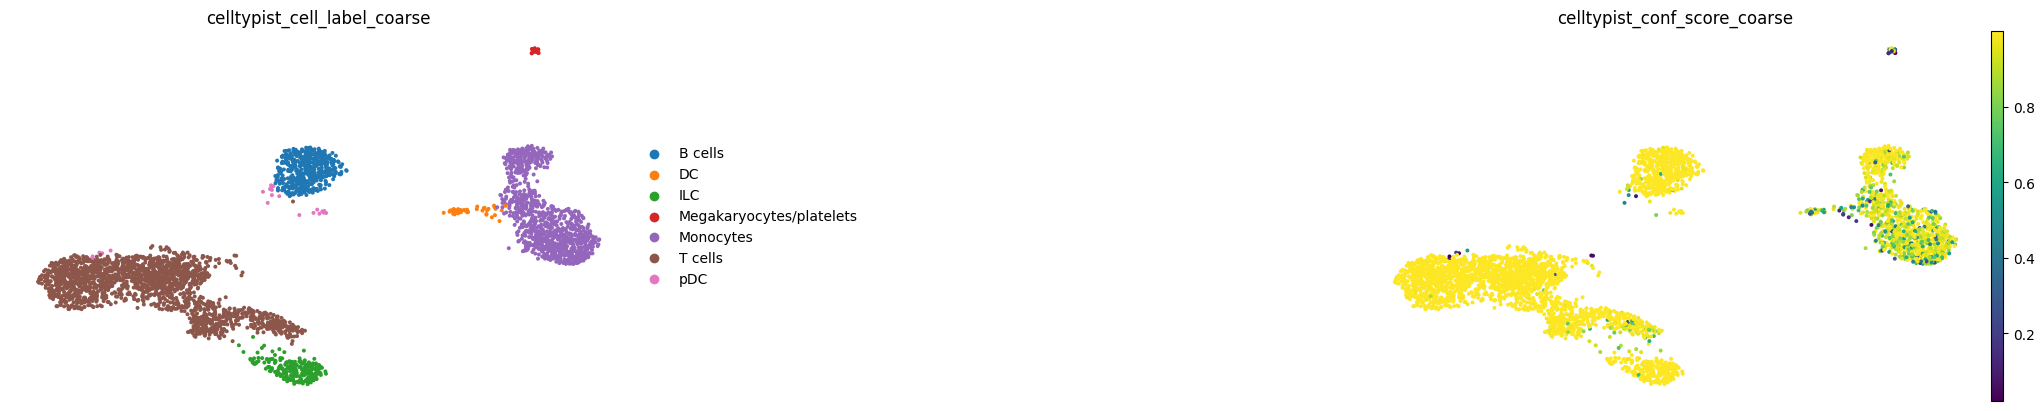

In [54]:
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_coarse", "celltypist_conf_score_coarse"],
    frameon=False,
    sort_order=False,
    wspace=1,
)

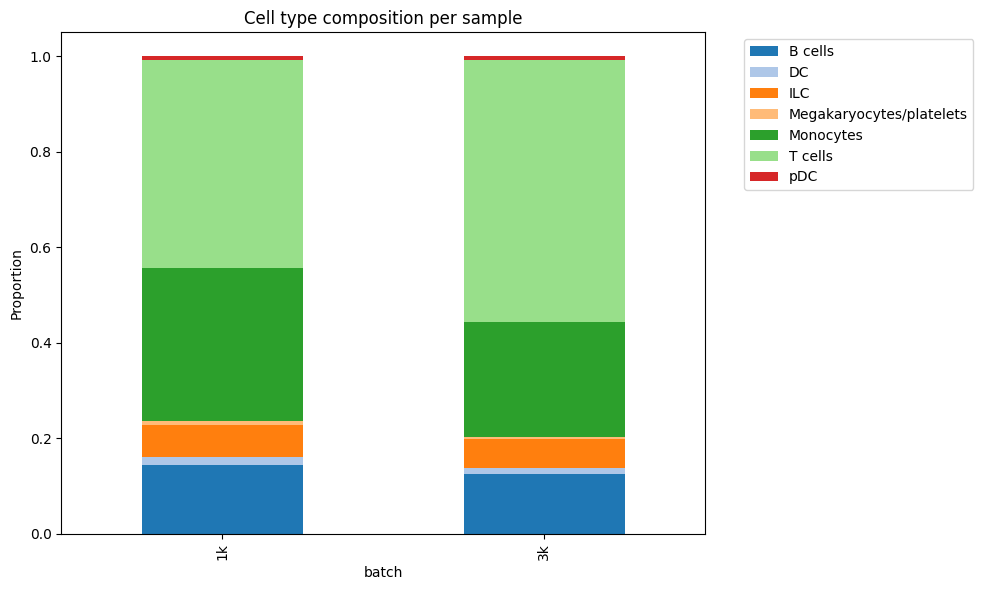

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# 交叉表：每个样本中各种细胞类型的数量
composition_counts = pd.crosstab(adata.obs['batch'], adata.obs['celltypist_cell_label_coarse'])

# 按行归一化为比例（optional）
composition_props = composition_counts.div(composition_counts.sum(axis=1), axis=0)

# 设置配色方案
cell_types = composition_props.columns
colors = plt.cm.tab20.colors[:len(cell_types)]

# 绘图
composition_props.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.ylabel('Proportion')
plt.title('Cell type composition per sample')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [56]:
del(adata.uns['wilc_leiden_filtered'])

In [57]:
adata.write_h5ad('pbmc_annotated.h5ad',compression='gzip')